In [1]:
import numpy as np
import pandas as pd

In [2]:
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celeba-dataset' dataset.
Path to dataset files: /kaggle/input/celeba-dataset


In [4]:
## Defining the path to the datasets
key_points_data_path = "/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv"
images_data_path = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

# Since, the dataset is very huge. Hence, we will only select 10000K images
images_data_size = 10000

# Original image dimensions
x_org = 178    # original x value
y_org = 218    # original y value

#Let's scale the images to new dimensions

# New image dimensions
x_ = 100                            # new value of x
image_size_ratio = x_org / y_org    # dimensions ratio
y_ = int(image_size_ratio * x_)     # new value of y

# Image Sizes
original_image_size = (x_org, y_org)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size


## Loading the key points data

In [5]:
# load the dataset (key points)
df_org = pd.read_csv(key_points_data_path)
df_org = df_org[:images_data_size]

## Converting images into an array

In [6]:
images_data = list()
for idx in range(df_org.shape[0]):
    # Retrieving the path based upon the index
    path = "{}/{}".format(str(images_data_path),str(df_org.iloc[idx].image_id))

    # Reading images using PIL library
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255

    # Appending the images to a list
    images_data.append(image_array)

# Converting images_data to an array from list
images_data = np.array(images_data)

## Plotting a sample image

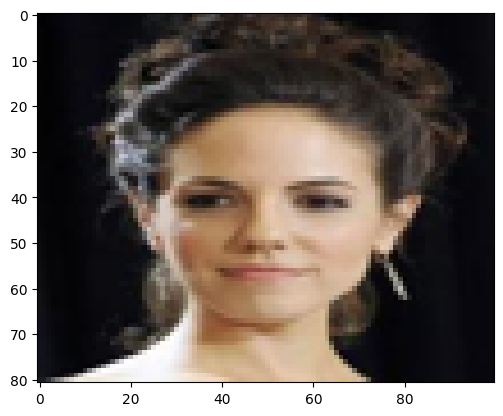

In [7]:
# Plotting a sample image
plt.imshow(images_data[700])

In [8]:
print("Images Data Arrays Shape:", images_data.shape)
print("Key Points Data Shape:", df_org.shape)

Images Data Arrays Shape: (10000, 81, 100, 3)
Key Points Data Shape: (10000, 11)


In [9]:
df_org.isnull().sum()

,0
image_id,0
lefteye_x,0
lefteye_y,0
righteye_x,0
righteye_y,0
nose_x,0
nose_y,0
leftmouth_x,0
leftmouth_y,0
rightmouth_x,0


In [10]:
df_org.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,69.350000,111.200200,107.645500,111.164800,87.933500,135.110900,71.244600,152.08370,105.590700,152.212000
std,1.706983,1.143526,1.690892,1.169349,6.665112,4.272988,3.175623,1.78718,3.249558,1.742114
min,60.000000,99.000000,90.000000,101.000000,59.000000,104.000000,60.000000,144.00000,91.000000,139.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.00000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.00000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,73.000000,153.00000,108.000000,153.000000
max,85.000000,121.000000,121.000000,117.000000,120.000000,150.000000,87.000000,166.00000,116.000000,170.000000


## Reading images

In [11]:
# function to read images based on index
def image_array(index, size=image_size_training, path=images_data_path):
    """
    This functions is for converting images to arrays to deal with it in the model.

    Input:  index of the image that we want to convert to array
            size of the image that we want for the array of the image
            path of the images data to get the image

    Output: the image array as numpy array
    """
    # to get the path based on index
    path = "{}/{}".format(str(path),str(df_org.iloc[index].image_id))

    # to read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)

    return image_array

In [12]:
# function to get a list of all key points of the face
def image_key_points_list(index, df = df_org):
    """
    This function for getting the key points on the face as list to deal with it in plotting sections
    """
    # box dictionary
    points_list = [df.iloc[index].lefteye_x,
                   df.iloc[index].lefteye_y,
                   df.iloc[index].righteye_x,
                   df.iloc[index].righteye_y,
                   df.iloc[index].nose_x,
                   df.iloc[index].nose_y,
                   df.iloc[index].leftmouth_x,
                   df.iloc[index].leftmouth_y,
                   df.iloc[index].rightmouth_x,
                   df.iloc[index].rightmouth_y]

    return points_list

In [13]:
# function to plot the image with green box around the faces
def plotting_image_with_box(index, df = df_org, size=original_image_size):
    """
    This function for plotting the image with points on facial features and box around the face
    """
    test_image = image_array(index, size)
    points_list = image_key_points_list(index, df)

    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], 'bo-')

    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect);

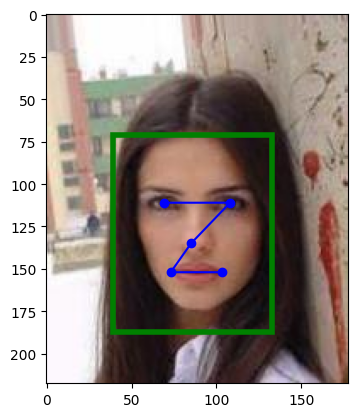

In [14]:
#plotting the image with facial key points
plotting_image_with_box(25)

## Preparing the data for our Deep Learning

### Now, we will rescale the keypoints on the basis of rescaled images

In [15]:
# copy a version from the data to prepare it for analysis
df = df_org.copy()

# check
df.head(3)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158


In [16]:
# function for updating key points for a new size
def rescale_key_points(oldsize=original_image_size, newsize=image_size_training):
    """
    This function is for rescaling the key points from the original scale to a nwe scale from our chossen and we reduce
    the image size to make the analysis faster and using lower memory
    """
    # old and nwe sizes (x,y) values
    x_axis_old = oldsize[0]
    y_axis_old = oldsize[1]

    x_axis_new = newsize[0]
    y_axis_new = newsize[1]

    x_ratio = x_axis_new / x_axis_old
    y_ratio = y_axis_new / y_axis_old

    # converting the keypoints values to be trained with the new size of the images
    keypoints_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
    keypoints_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

    df[keypoints_x] = (df[keypoints_x] * x_ratio).astype('int')
    df[keypoints_y] = (df[keypoints_y] * y_ratio).astype('int')

    return 0

# call the function
rescale_key_points()

# check
df.head()


,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,38,40,59,41,43,52,41,56,60,57
1,000002.jpg,38,40,60,41,45,50,39,56,60,56
2,000003.jpg,42,41,58,39,60,47,41,57,55,58
3,000004.jpg,40,41,60,40,56,51,39,57,56,56
4,000005.jpg,37,42,62,41,48,44,39,54,58,55


In [17]:
images=images_data
labels=df

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train_images,test_images,train_labels,test_labels=train_test_split(images,labels,
                                                                  test_size=0.3,random_state=42)

In [20]:
y_test=test_labels.drop(["image_id"],axis=1)
y_train=train_labels.drop(["image_id"],axis=1)

X_test=test_images
X_train=train_images

## Further splitting the test data into validation and test data

In [21]:
X_test, X_val, y_test, y_val=train_test_split(X_test, y_test,
                                              test_size=0.5,random_state=42)

## Building the CNN-based Deep Learning model

In [22]:
# diminsions of the image in the traing process
x_ = image_size_training[0]
y_ = image_size_training[1]

# build the model
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(y_,x_,3)))
model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Having a quick view of the model architecture

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 81, 100, 8)     │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 81, 100, 8)     │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 50, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       122,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,154 (598.26 KB)

 Trainable params: 153,154 (598.26 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer="rmsprop", loss='mean_squared_error',metrics=["mae"])

In [25]:
# fitting the model with our data
training_process = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=4, shuffle=True)

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 617.7432 - mae: 19.4506 - val_loss: 79.0106 - val_mae: 8.5972
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 118.1267 - mae: 8.6023 - val_loss: 65.8657 - val_mae: 7.8414
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 97.3100 - mae: 7.7198 - val_loss: 89.4921 - val_mae: 9.1870
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 88.1719 - mae: 7.3580 - val_loss: 58.1833 - val_mae: 7.3441
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 83.6326 - mae: 7.1760 - val_loss: 71.7458 - val_mae: 8.1894
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 77.1136 - mae: 6.9157 - val_loss: 107.6088 - val_mae: 10.0966
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 72.2046 - mae: 6.6632 - val_loss: 41.6148 - val_mae: 6.1697
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 67.4990 - mae: 6.4452 - val_loss: 49.9970 - val_mae: 6.7993
Epoch 9/50
1750/17

## Testing the model

### Evaluating the model performance on the basis of

In [26]:
model.evaluate(X_test, y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8223 - mae: 1.1085


[2.86142897605896, 1.1152530908584595]

In [27]:
def predictions_test_model(index):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]

    # converting key points values to the original size
    x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
    y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
    """
    In the previous ratios we multiply them by contant to reduce the noise that happened when we rescaled the points in
    the previous training, there is no meaning for these numbers (i just pick them with trails)
    """

    points_list[0] = int(points_list[0] * x_ratio)
    points_list[2] = int(points_list[2] * x_ratio)
    points_list[4] = int(points_list[4] * x_ratio)
    points_list[6] = int(points_list[6] * x_ratio)
    points_list[8] = int(points_list[8] * x_ratio)

    points_list[1] = int(points_list[1] * y_ratio)
    points_list[3] = int(points_list[3] * y_ratio)
    points_list[5] = int(points_list[5] * y_ratio)
    points_list[7] = int(points_list[7] * y_ratio)
    points_list[9] = int(points_list[9] * y_ratio)

    return points_list

In [28]:
# function to plot the image with green box around the faces
def test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='bo-' ,boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_org,x_org,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255

    # predictions of key points on the face
    if pred_or_actual == 'pred':
        points_list = predictions_test_model(index)        # this for predections of the model
    elif pred_or_actual == 'actual':
        points_list = image_key_points_list(index)   # this for the actual labels of the test data

    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)

    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

RED box for predections

GREEN box for actual labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


array([ 71, 116, 110, 116,  89, 143,  72, 160, 108, 160])

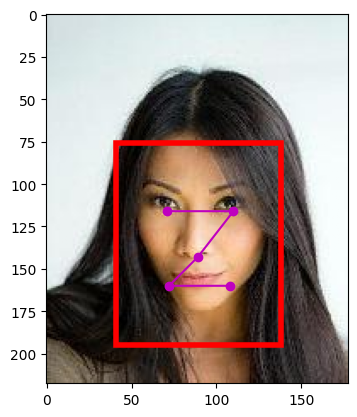

In [29]:
# Using the model to predict a sample image which doesn't exist in train,test, or validation data
index = 34100
print('RED box for predections\n')
print('GREEN box for actual labels\n')
test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='mo-' ,boxcolor='r')


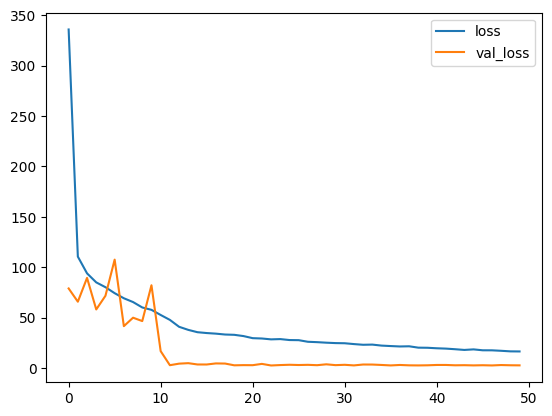

In [30]:
# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

## Saving the model for future use

In [31]:
model.save("model.h5")